# 📘 Model Calibration: Improving Probability Predictions in Classification
**Dataset:** Breast Cancer Wisconsin (Diagnostic)
**Goal:** Calibrate predicted probabilities using reliability diagrams and Brier score

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM (Platt Scaling)": CalibratedClassifierCV(estimator=SVC(probability=True), method='sigmoid', cv=3)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"\n{name} Evaluation:")
    y_probs = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_probs)
    print("Brier Score:", round(brier, 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, model.predict(X_test)))
    print(classification_report(y_test, model.predict(X_test)))


Logistic Regression Evaluation:
Brier Score: 0.0283
Confusion Matrix:
 [[40  3]
 [ 1 70]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114


Random Forest Evaluation:
Brier Score: 0.0274
Confusion Matrix:
 [[40  3]
 [ 2 69]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


SVM (Platt Scaling) Evaluation:
Brier Score: 0.0374
Confusion Matrix:
 [[37  6]
 [ 0 71]]
              precision    recall  f1-score   support

           0       1.00 

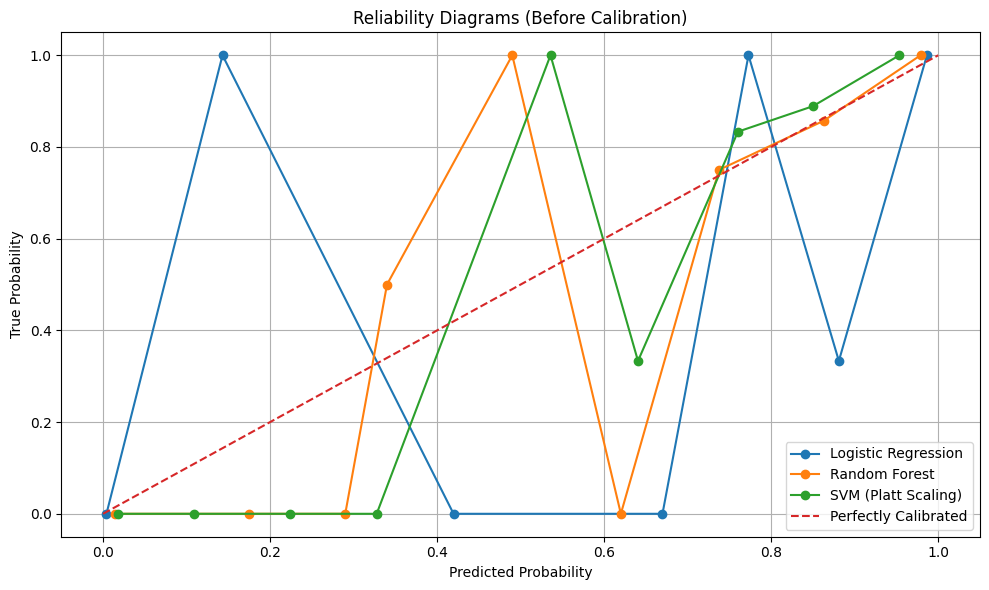

In [6]:
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Reliability Diagrams (Before Calibration)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

# Replace 'base_estimator' with 'estimator'
rf_sigmoid = CalibratedClassifierCV(estimator=rf, method='sigmoid', cv=3)
rf_isotonic = CalibratedClassifierCV(estimator=rf, method='isotonic', cv=3)

rf_sigmoid.fit(X_train, y_train)
rf_isotonic.fit(X_train, y_train)

CalibratedClassifierCV(cv=3, estimator=RandomForestClassifier(),
                       method='isotonic')

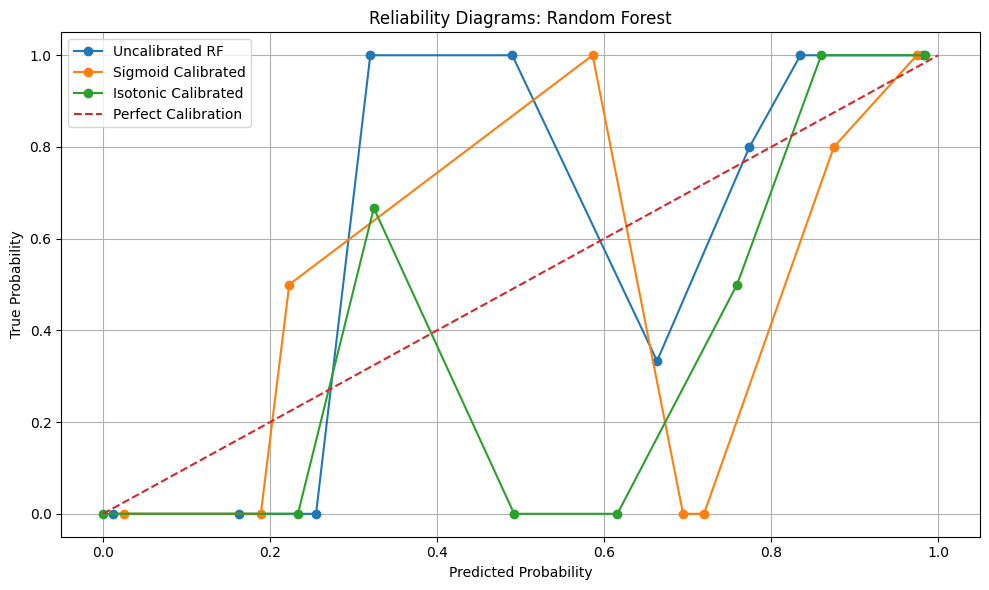

In [9]:
plt.figure(figsize=(10, 6))
for name, model in zip(["Uncalibrated RF", "Sigmoid Calibrated", "Isotonic Calibrated"],
                       [rf, rf_sigmoid, rf_isotonic]):
    y_probs = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Reliability Diagrams: Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
models_final = {
    "RF Uncalibrated": rf,
    "RF Sigmoid": rf_sigmoid,
    "RF Isotonic": rf_isotonic
}

for name, model in models_final.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    score = brier_score_loss(y_test, y_probs)
    print(f"{name}: Brier Score = {score:.4f}")

RF Uncalibrated: Brier Score = 0.0257
RF Sigmoid: Brier Score = 0.0241
RF Isotonic: Brier Score = 0.0213
